In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [89]:
print(np.sqrt(5.3*8.4), (5.3+8.4)/2)

6.672330927044911 6.85


# Define functions to create a lognormal distribution given its median and either one or two quantiles

Note that since lognormal is a 2-parameter distribution, specifying the median and one other quantile will determine the distribution exactly, whereas specifying the median and two quantiles is an overdetermined system, so the resulting distribution in the second case will in general only approximate the specified quantiles.

In [2]:
np.log([3,4])

array([1.09861229, 1.38629436])

In [85]:
def lognorm_from_median_and_quantile(median, quantile, quantile_rank):
    """Returns a frozen lognormal distribution with the specified median and quantile
    of rank quantile_rank, which must be different from 0.5.
    """
    # Let Y ~ Norm(mu, sigma^2) and X = exp(Y), where mu = log(median)
    # so X ~ Lognorm(s=sigma, scale=exp(mu)) in scipy's notation.
    # We need to determine sigma from the median and quantile.
    
    # quantile of standard normal distribution corresponding to quantile_rank
    #(quantile is approximately 1.96 for quantile_rank=0.975)
    stdnorm_quantile = stats.norm().ppf(quantile_rank)

    mu = np.log(median) # mean of normal distribution for Y = log(X)
    sigma = (np.log(quantile) - mu) / stdnorm_quantile # std dev of normal distribution for Y=log(X)

    # Frozen lognormal distribution for X = exp(Y)
    # (s=sigma is the shape parameter; the scale parameter is exp(mu), which equals the median)
    return stats.lognorm(s=sigma, scale=median)

def lognorm_from_median_lower_upper(median, lower, upper, quantile_ranks=(0.025,0.975)):
    """Returns a frozen lognormal distribution with the specified median, such that
    (lower, upper) are approximately equal to the quantiles with ranks
    (quantile_ranks[0], quantile_ranks[1]). More precisely, if q0 and q1 are
    the quantiles of the returned distribution with ranks quantile_ranks[0]
    and quantile_ranks[1], respectively, then q1/q0 = upper/lower. If the 
    quantile ranks are symmetric about 0.5, lower and upper will coincide with
    q0 and q1 precisely when median^2 = lower*upper.
    """
    # Let Y ~ Norm(mu, sigma^2) and X = exp(Y), where mu = log(median)
    # so X ~ Lognorm(s=sigma, scale=exp(mu)) in scipy's notation.
    # We will determine sigma from the two specified quantiles lower and upper.
    
    # mean (and median) of the normal random variable Y = log(X)
    mu = np.log(median)
    # quantiles of the standard normal distribution corresponding to quantile_ranks
    stdnorm_quantiles = stats.norm.ppf(quantile_ranks)
    # quantiles of Y = log(X) corresponding to the quantiles (lower, upper) for X
    norm_quantiles = np.log([lower, upper])
    # standard deviation of Y = log(X) computed from the above quantiles for Y
    # and the corresponding standard normal quantiles
    sigma = (norm_quantiles[1] - norm_quantiles[0]) / (stdnorm_quantiles[1] - stdnorm_quantiles[0])
    # Frozen lognormal distribution for X = exp(Y)
    # (s=sigma is the shape parameter; the scale parameter is exp(mu), which equals the median)
    return stats.lognorm(s=sigma, scale=median)

def lognorm_from_median_lower_upper_exact(
    median, lower, upper, desired_prob=.95, initial_p0=None, max_iterations=1000, rtol=1e-05, atol=1e-08):
    """Returns a frozen lognormal distribution with the specified median, such that
    the probability content of the interval (lower, upper) is `desired_prob`,
    assuming such a distribution exists. If no such distribution exists, returns its best
    guess after `max_iterations` iterations of binary search.
    """
    residual_prob = 1-desired_prob
    # Initialize lower quantile rank p0
    p0 = residual_prob/2 if initial_p0 is None else initial_p0
    # Do a binary search for the correct lower quantile rank p0
    found = False
    iterations = 0
    while not found and iterations <= max_iterations:
        dist = lognorm_from_median_lower_upper(median, lower, upper, (p0, p0+desired_prob))
        prob = dist.cdf(upper) - dist.cdf(lower)
        if np.allclose(prob, desired_prob, rtol, atol):
            found = True
        # These checks assume median is contained in the interval (lower, upper)
        elif prob < desired_prob:
            # need to reduce spread -> move p0 left
            residual_prob = p0
            p0 = p0/2
        else: # prob > desired_prob
            # need to increase spread -> move p0 right
            p0 = (p0+residual_prob)/2
        iterations +=1
    print(iterations)
    return dist

In [32]:
(.05+.025)/2

0.037500000000000006

In [38]:
dist_exact = lognorm_from_median_lower_upper_exact(median, lower, upper)
dist_exact.kwds

18


{'s': 0.1174063100590593, 'scale': 6.7}

# Check some standard normal quantiles

In [4]:
stats.norm.ppf(0.975)

1.959963984540054

In [5]:
stats.norm.ppf(0.975) - stats.norm.ppf(0.025)

3.9199279690801085

# Create 3 slightly different lognormal distributions for K parameter from Isanaka paper

In [6]:
median = 6.7
lower = 5.3
upper = 8.4

dist_lower = lognorm_from_median_and_quantile(median, lower, 0.025)
dist_upper = lognorm_from_median_and_quantile(median, upper, 0.975)
dist_both = lognorm_from_median_lower_upper(median, lower, upper)

# Verify that the median is 6.7 for all three

In [7]:
print([dist.median() for dist in [dist_lower, dist_upper, dist_both]])

[6.7, 6.7, 6.7]


# Check mean, variance, skew, kurtosis for each version

In [8]:
dist_lower.stats('mvsk')

(array(6.74808618), array(0.65598273), array(0.36179892), array(0.2336203))

In [9]:
dist_upper.stats('mvsk')

(array(6.74473924), array(0.60956738), array(0.34882084), array(0.21710108))

In [10]:
dist_both.stats('mvsk')

(array(6.74639747), array(0.6325494), array(0.35530706), array(0.22528056))

In [25]:
dist_lower.kwds

{'s': 0.11959439443161571, 'scale': 6.7}

In [26]:
dist_upper.kwds

{'s': 0.11537159929263298, 'scale': 6.7}

In [27]:
dist_both.kwds

{'s': 0.11748299686212435, 'scale': 6.7}

# Check 95% interval = `(dist.ppf(0.025), dist.ppf(0.975))` for each version

median = 6.7
lower = 5.3
upper = 8.4

In [11]:
dist_lower.interval(.95)

(5.299999999999999, 8.469811320754719)

In [12]:
dist_upper.interval(.95)

(5.34404761904762, 8.399999999999999)

In [13]:
dist_both.interval(.95)

(5.321978239428678, 8.434833436075643)

In [87]:
i = dist_both.interval(.95)
print(i[1]/i[0], 8.4/5.3)

1.5849056603773588 1.5849056603773586


In [14]:
dist_upper.ppf(.975)

8.399999999999999

In [15]:
dist_both.ppf(.975) - dist_both.ppf(.025)

3.112855196646964

In [28]:
dist_both.cdf(8.4) - dist_both.cdf(5.3)

0.9498578588175031

In [30]:
(dist_upper.cdf(8.4) - dist_upper.cdf(5.3))

0.9539080819334941

In [31]:
(dist_lower.cdf(8.4) - dist_lower.cdf(5.3))

0.9456717397479854

In [36]:
(dist_exact.cdf(8.4) - dist_exact.cdf(5.3))

0.9500073919872631

In [22]:
def relative_error(x,y):
    return (x-y)/y

In [35]:
print([relative_error(dist.cdf(8.4)-dist.cdf(5.3), .95) for dist in [dist_lower, dist_upper, dist_both, dist_exact]])

[-0.004556063423173268, 0.004113770456309603, -0.00014962229736514843, 7.78103922440353e-06]


# Plot densities

In [39]:
def plot_pdf(ax, dist, label):
    x = np.linspace(dist.ppf(0.01), dist.ppf(0.99), 100)
    ax.plot(x, dist.pdf(x), lw=2, alpha=0.8, label=label)

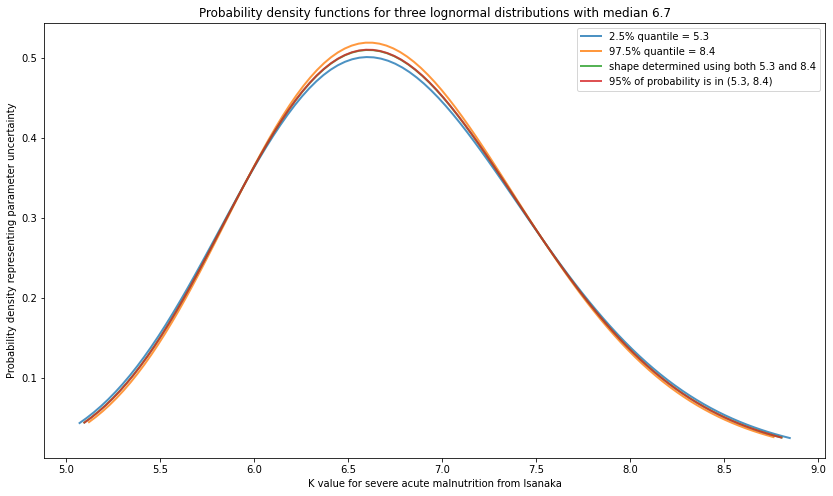

In [41]:
fig, ax = plt.subplots(figsize=(14,8))
plot_pdf(ax, dist_lower, '2.5% quantile = 5.3')
plot_pdf(ax, dist_upper, '97.5% quantile = 8.4')
plot_pdf(ax, dist_both, 'shape determined using both 5.3 and 8.4')
plot_pdf(ax, dist_exact, '95% of probability is in (5.3, 8.4)')
ax.legend()
ax.set_title("Probability density functions for three lognormal distributions with median 6.7")
ax.set_xlabel('K value for severe acute malnutrition from Isanaka')
ax.set_ylabel('Probability density representing parameter uncertainty');

# Let's go with the distribution that uses both 5.3 and 8.4 since it's in between

58
d0.kwds={'s': 0.35365301915106695, 'scale': 5}, d1.kwds={'s': 0.30660667488965027, 'scale': 5}
[(2.5000000000000004, 9.999999999999998), (2.7414853504743113, 9.119144114950199)]
[0.9190379605880833, 0.9499999472314544]


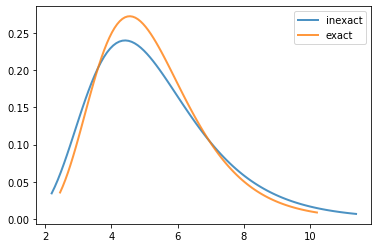

In [73]:
d0 = lognorm_from_median_lower_upper(5,3,12)
d1 = lognorm_from_median_lower_upper_exact(5,3,12, .95, rtol=1e-7)
print(f"{d0.kwds=}, {d1.kwds=}")
print([d.interval(.95) for d in [d0,d1]])
print([d.cdf(12)-d.cdf(3) for d in [d0,d1]])
plot_pdf(plt.gca(), d0, 'inexact')
plot_pdf(plt.gca(), d1, 'exact')
plt.legend()

In [49]:
d1.interval(.95)

(2.741445851775875, 9.11927550340099)

In [50]:
d1.cdf(12)-d1.cdf(3)

0.9499955061697142

27
{'s': 0.1749046976542692, 'scale': 2}
(1.4195505003202786, 2.817793378324703)
0.9999999191879665-0.050006223576026035 = 0.9499936956119405


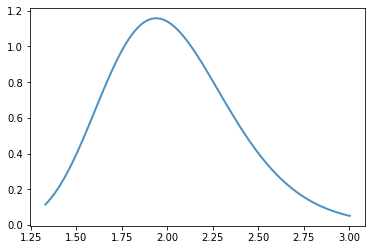

In [72]:
d2 = lognorm_from_median_lower_upper_exact(2,1.5,5, .95)
print(d2.kwds)
print(d2.interval(.95))
print(f"{d2.cdf(5)}-{d2.cdf(1.5)} = {d2.cdf(5)-d2.cdf(1.5)}")
fig, ax = plt.subplots()
plot_pdf(ax, d2, '')

In [69]:
d2.sf([3,5])

array([1.02190658e-02, 8.08120335e-08])

In [63]:
d2.mean()

2.0308268130316924

96
{'s': 0.1108482958162959, 'scale': 5}
(4.02360893485017, 6.213327489027197)
0.9499928682662206


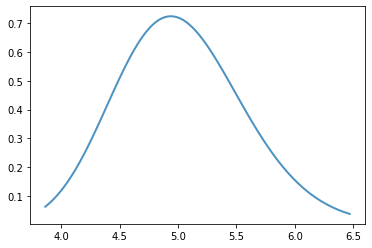

In [75]:
m=5
l=1.5
u=6
prob=.95
d2 = lognorm_from_median_lower_upper_exact(m,l,u, prob)
print(d2.kwds)
print(d2.interval(prob))
print(d2.cdf(u)-d2.cdf(l))
fig, ax = plt.subplots()
plot_pdf(ax, d2, '')

In [81]:
print(d2.cdf(l), d2.cdf(u))

8.79702340160916e-28 0.9499928682662206


In [80]:
d2prime = lognorm_from_median_lower_upper(m, l, u, (d2.cdf(l), d2.cdf(u)))
d2prime.kwds

{'s': 0.11084829581629589, 'scale': 5}

1001
{'s': 0.025243280879074282, 'scale': 1}
(0.9517280741643348, 1.0507202920099319)
0.0


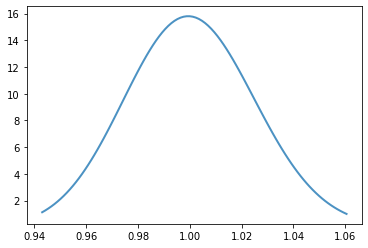

In [86]:
m=1
l=3
u=8
prob=.95
d = lognorm_from_median_lower_upper_exact(m,l,u, prob)
print(d.kwds)
print(d.interval(prob))
print(d.cdf(u)-d.cdf(l))
fig, ax = plt.subplots()
plot_pdf(ax, d, '')